In [24]:
import numpy as np
import math

# Computer Experiments with Accelerated by Coupling Directional Search (ACDS) Method

<i>Alexander Gasnikov</i> 
<br/>
<i>Moscow Institute of Physics and Technology  (Moscow, Russia)</i>
<br/>
<i>Eduard Gorbunov</i> 
<br/>
<i>Moscow Institute of Physics and Technology (Moscow, Russia)</i>
<br/>
<i>Evgeniya Vorontsova</i> 
<br/>
<i>Far Eastern Federal University (Vladivostok, Russia)</i>

Article: https://arxiv.org/abs/1710.00162v1

Let $A$ be a real random matrix $n \times n$ with elements from $[0, \, 1]$. 
$$
B = \frac{A^T A}{\lambda_{max}(A^T A)}, \quad x^* = (1, \, 0, \, 0, \, \ldots, \, 0). 
$$

Function to be minimized: $f = \frac{1}{2} \langle x - x^*, \, B(x - x^*) \rangle \, \rightarrow \, \min\limits_x$.


In [25]:
# Power iteration algorithm (eigenvalue algorithm)
def power_iteration(A, maxiter):
    
    b_k = np.random.rand(A.shape[0])
    
    for k in range(0, maxiter):
        # calculate the matrix-by-vector product Ab
        b_k1 = np.dot(A, b_k)

        # calculate the norm
        b_k1_norm = np.linalg.norm(b_k1)

        # re normalize the vector
        b_k = b_k1 / b_k1_norm

    return b_k

In [26]:
n = 10; # Dimension of vector space
x_star = np.zeros(n).reshape(n, 1);
x_star[0] = 1;

A = np.random.rand(n, n);
B = (A.T).dot(A);

# Find B eigenvector associated with the dominant eigenvalue
e_vect = power_iteration(B, 1000)

e_vect_tr = e_vect.reshape(1, e_vect.size)

# Rayleigh quotient
# Dominant eigenvalue of B
e_value = np.dot(e_vect_tr, np.dot(B, e_vect)) / np.dot(e_vect_tr, e_vect)

B = B / e_value
#B = np.eye(n, n)
print(e_value)
#print(B.dot(e_vect))
#print(e_value*e_vect)
#[w, v] = np.linalg.eig(B)
#print(w)
#print(v)

[ 25.18932366]


In [27]:
f = lambda x: 1 / 2 * np.dot((x - x_star).reshape(1, n), np.dot(B, x - x_star))

In [28]:
#Initial point
x0 = np.zeros(n).reshape(n, 1);
x0[n-1] = 1;

L = 1

y0 = x0
z0 = x0

f_star = f(x_star)
f_x = f(x0)

In [29]:
# Generating uniformly distributed numbers on a sphere
def get_rand_vec(dims):
    e = np.random.standard_normal(dims)
    return e / np.linalg.norm(e)

In [30]:
# Dikhotomy method for one-dimensional minimization 
def dihot(func, xa, xb, eps, maxit, a, c):
    
    fa = func(xa, a, c)
    fb = func(xb, a, c)
    if fa*fb > 0:
        print("Error - Dihotomy can't work!")
    
    iter = 0
    while abs(xb-xa) > eps and iter < maxit:  
        xc = (xa+xb) / 2
        fc = func(xc, a, c)
        #print("fc", fc)
        if fa*fc > 0:
            xa = xc
        else:
            xb = xc
            
        iter = iter + 1
    return xc

Распишем отдельно шаг метода для вычисления $z$, используя обозначения из статьи https://arxiv.org/ftp/arxiv/papers/1603/1603.07701.pdf.

Необходимо решить задачу
$$
\tilde{F}(z) = \langle c, \, z \rangle + \frac{1}{2(a-1)} \|z \|_a^2 \, \rightarrow \, \min_z
$$

С помощью метода множителей Лагранжа получаем
$$
\tilde{G}(\lambda) = \min_{t, \, z_k} \left \{ \sum_{k = 1}^n c_k z_k + \frac{1}{2(a-1)} t +  \lambda \left (\sum_{k=1}^n z_k^a - t^{a/2} \right ) \right \}.
$$


Необходимо решить задачу
$$
\max_{\lambda \, \ge \, 0} \tilde{G} (\lambda).
$$

Для этого найдем выражения для $t^*(\lambda)$ и $z_k^*(\lambda)$:
$$
t^* = \left [ \lambda a (a - 1) \right ]^{\frac{2}{2-a}}, \quad z_k^* = \left (-\frac{c_k}{\lambda a} \right )^{\frac{1}{a-1}}
$$

Пусть $\breve{G}(\lambda) = - \tilde{G}(\lambda)$. Тогда задача для решения
$$
\min_{\lambda \, \ge \, 0} \breve{G} (\lambda).
$$
При этом 
$$
\frac{\partial \breve{G}(\lambda)}{\partial \lambda} = t^*(\lambda)^{a/2} - \sum_{k=1}^n \left (z_k^*(\lambda) \right )^a
$$
Получилась задача одномерной минимизации, её можно решить простой дихотомией.

Примечание. В нашем случае $c = \alpha_{k+1} \langle B x^{k+1}, \, e^{k + 1} \rangle e^{k + 1} - \nabla d(z^k)$, $d(z) = \frac{1}{2(a-1)} \| z \|_a^2$, $a = 1 + \frac{1}{2 \ln n}$.


In [31]:
# Prox-function 
# z should be a vector, not a matrix (use np.ravel() to convert)
def d(z, a):
    norm_z = np.linalg.norm(z, a)
    return 1/ 2 / (a - 1) * norm_z* norm_z

In [32]:
#Gradient of prox-function 
def grad_d(z, a):
    g = np.zeros(n).reshape(n, 1)
    norm_z = np.linalg.norm(np.ravel(z), a)
    nzz = 1/ (a - 1)*pow(norm_z, 2 - a)
    for k in range(0, n):
        g[k] = nzz * pow(abs(z[k]), a - 1)
        
    return g

In [33]:
#Gradient G(lambda) 
def grad_G(lam, a, c):
    z = np.zeros(n).reshape(n, 1)
    g = np.zeros(n).reshape(n, 1)
    
    t = pow(lam * a * (a - 1), 2 / (2 - a))
    
    sum_z = 0
    for k in range(0, n):
        z[k] = pow( abs(- c[k] / lam / a), 1 / (a - 1))
        sum_z = sum_z + pow(z[k], a)
        
    g = pow(t, a / 2) - sum_z
    return g

In [34]:
eps = 1e-3

p = 1 + 1 / (2 * math.log(n))
q = p / (p - 1)

C_const = 4 / 3 * min([q - 1, 4 * math.log(n)]) * pow(n, 2/q + 1)

L = 1

N = 2 * math.sqrt(math.log(n) * L * C_const / eps)
print("Number of iteration (required):", math.ceil(N))

Number of iteration (required): 1135


In [35]:
k = 0

x = x0
z = z0
y = y0

f_y = f_x

maxit = 748

plt1 = []

while abs(f_y - f_star) > eps and k < maxit:
    tau = 2. / (k + 2)
    x = tau * z + (1 - tau) * y
    
    e = get_rand_vec(n)
        
    bxe = np.dot(np.dot(B, x - x_star).reshape(1, n), e) * e;
    
    y = x - 1. / L * bxe.reshape(n, 1);
        
    alpha = (k + 2) / 2 / L / C_const;
    
    c = alpha*n*bxe.reshape(n, 1) - grad_d(z, p)
    
    lam = dihot(grad_G, eps, 100, eps/100, 10*maxit, p, c)
        
    for ii in range(0, n):
        z[ii] = pow( abs(- c[ii] / lam / p), 1 / (p - 1))
        
    f_y = f(y)
    plt1.append(abs(f_y[0][0]))
    
    #print("f_y", f_y, iter)
    
    k = k + 1
print(k, f_y)    

537 [[ 0.00098926]]


<IPython.core.display.Javascript object>


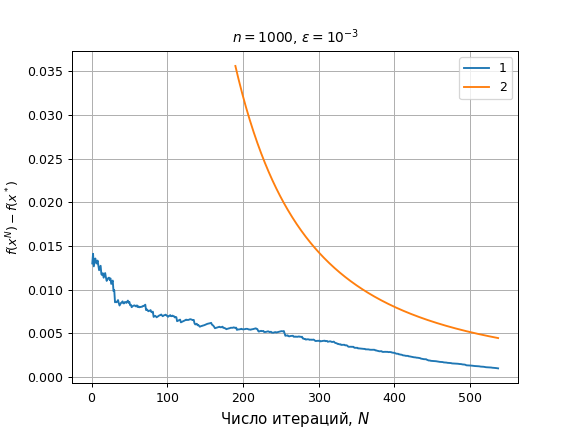

In [50]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.grid(True)
plt.plot(range(1, k + 1), plt1, label = '1')
plt.plot(range(190, k + 1), [math.log(n)*4*C_const/k/k for k in range(190, k + 1)], label='2')
plt.xlabel(r"Число итераций, $N$", fontsize=12)
plt.ylabel(r"$f(x^N)- f(x^*) $", fontsize=10)
plt.title(r"$n = 1000, \, \varepsilon = 10^{-3}$", fontsize = 11);
plt.legend()